# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 17, 17, 6, 9, 809099)

### <span style='color:#ff5f27'> 🚨 Select running mode

In [4]:
#Select whether part E, C or A is run

running_e = False
running_c = False
running_a = True 

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

if running_e or running_c:
    location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
    location = json.loads(location_str)
    country=location['country']
    city=location['city']
    street=location['street']

if running_a:
    locations_str = secrets.get_secret("SENSOR_LOCATIONS_JSON").value
    locations = json.loads(locations_str)
    country=locations[0]['country']
    city=locations[0]['city']

2025-11-17 17:06:13,194 INFO: Initializing external client
2025-11-17 17:06:13,198 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 17:06:13,855 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 17:06:14,646 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272015


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

#Model 5 for lagged features!

if running_c:
    retrieved_model = mr.get_model(
        name="air_quality_xgboost_model", 
        version=5, #<-- byt här
    )

if running_a:
    retrieved_model = mr.get_model(
        name="air_quality_xgboost_model", 
        version=6, #<-- byt här
    )

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-17 17:06:20,960 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/514899 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/551434 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/534022 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/512167 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/498285 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/502074 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120025 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120343 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117623 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118497 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115008 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115107 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25972 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26161 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26629 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25964 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25944 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26666 elapsed<00:00 remaining<?

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")

if running_e or running_c:
    retrieved_xgboost_model = XGBRegressor()

    retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

    # Displaying the retrieved XGBoost regressor model
    retrieved_xgboost_model

if running_a:
    models = []
    i=0
    for location in locations:
        retrieved_xgboost_model = XGBRegressor()
        retrieved_xgboost_model.load_model(saved_model_dir + "/model" + str(locations[i]['street']) + ".json")
        models.append(retrieved_xgboost_model)



## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
#Select version of feature group
if running_e:
    w_version = 1

if running_c:
    w_version = 1

if running_a:
    w_version = 2

weather_fg = fs.get_feature_group(
    name='weather',
    version=w_version,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh
1,2025-11-19 00:00:00+00:00,2.25,0.0,16.279802,305.095886,edinburgh
2,2025-11-20 00:00:00+00:00,4.15,0.0,17.654686,343.412567,edinburgh
3,2025-11-21 00:00:00+00:00,3.05,0.0,9.449572,229.635544,edinburgh
4,2025-11-22 00:00:00+00:00,5.90,0.3,15.188415,174.559753,edinburgh
5,2025-11-23 00:00:00+00:00,4.90,0.1,6.379216,286.389618,edinburgh


## <span style="color:#ff5f27;">✨ Del C - Populate lagging features   </span>


In [12]:
#Select version of feature group
if running_e:
    aq_version = 1

if running_c:
    aq_version = 2

if running_a:
    aq_version = 3

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=aq_version,
)
batch_data.sort_values("date")
batch_data.rename(columns={'temperature_2m_mean' : 'weather_temperature_2m_mean', 'precipitation_sum' : 'weather_precipitation_sum','wind_speed_10m_max' : 'weather_wind_speed_10m_max', 'wind_direction_10m_dominant' : 'weather_wind_direction_10m_dominant'}, inplace=True)

if running_c:

    aq_df = air_quality_fg.read().sort_values("date")[-3:]
    aq_df

    for i in range (batch_data.shape[0]):
        if i == 0:
            lagged1_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=1))]
            lagged2_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
            lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged1_df.empty:
                batch_data.loc[i, "lagged_aq_1_day"] = lagged1_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_1_day"] = 'NaN'
            if not lagged2_df.empty:
                batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
            if not lagged3_df.empty:
                batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

        elif i==1:
            batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
            
            lagged2_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
            lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged2_df.empty:
                batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
            if not lagged3_df.empty:
                batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

        elif i==2:
            batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
            batch_data.loc[i, "lagged_aq_2_days"] = batch_data.iloc[i-2]['predicted_pm25']
            
            lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged3_df.empty:
                batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'
            
        else:
            batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
            batch_data.loc[i, "lagged_aq_2_days"] = batch_data.iloc[i-2]['predicted_pm25']
            batch_data.loc[i, "lagged_aq_3_days"] = batch_data.iloc[i-3]['predicted_pm25']

        batch_data.loc[i,'predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])[i]

if running_a:
    batch_data_frames = []
    for location in locations:
        j=0
        street = location['street']

        aq_df = air_quality_fg.filter(air_quality_fg.street == street)
        aq_df = air_quality_fg.read()
        aq_df = aq_df[aq_df['street'] == street]
        aq_df = aq_df.sort_values("date")[-3:]

        for i in range (batch_data.shape[0]):
            if i == 0:
                lagged1_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=1))]
                lagged2_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
                lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
                
                if not lagged1_df.empty:
                    batch_data.loc[i, "lagged_aq_1_day"] = lagged1_df["pm25"].values[0]
                else:
                    batch_data.loc[i, "lagged_aq_1_day"] = 'NaN'
                if not lagged2_df.empty:
                    batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
                else:
                    batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
                if not lagged3_df.empty:
                    batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
                else:
                    batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

            elif i==1:
                batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
                
                lagged2_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
                lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
                
                if not lagged2_df.empty:
                    batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
                else:
                    batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
                if not lagged3_df.empty:
                    batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
                else:
                    batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

            elif i==2:
                batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
                batch_data.loc[i, "lagged_aq_2_days"] = batch_data.iloc[i-2]['predicted_pm25']
                
                lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
                
                if not lagged3_df.empty:
                    batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
                else:
                    batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'
                
            else:
                batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
                batch_data.loc[i, "lagged_aq_2_days"] = batch_data.iloc[i-2]['predicted_pm25']
                batch_data.loc[i, "lagged_aq_3_days"] = batch_data.iloc[i-3]['predicted_pm25']

            batch_data['lagged_aq_1_day'] = batch_data['lagged_aq_1_day'].astype(float)
            batch_data['lagged_aq_2_days'] = batch_data['lagged_aq_2_days'].astype(float)
            batch_data['lagged_aq_3_days'] = batch_data['lagged_aq_3_days'].astype(float)
            batch_data.loc[i,'predicted_pm25'] = models[j].predict(
            batch_data[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant']])[i]
        batch_data_frames.append(batch_data)
        j+=1
        
batch_data_frames[0]


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.83s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.07s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,city,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,predicted_pm25,street,country
0,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,18.000000,17.000000,20.000000,22.494715,queensferry road,united-kingdom
1,2025-11-19 00:00:00+00:00,2.25,0.0,16.279802,305.095886,edinburgh,22.494715,18.000000,17.000000,19.152739,queensferry road,united-kingdom
2,2025-11-20 00:00:00+00:00,4.15,0.0,17.654686,343.412567,edinburgh,19.152739,22.494715,18.000000,16.753971,queensferry road,united-kingdom
3,2025-11-21 00:00:00+00:00,3.05,0.0,9.449572,229.635544,edinburgh,16.753971,19.152739,22.494715,24.861761,queensferry road,united-kingdom
4,2025-11-22 00:00:00+00:00,5.90,0.3,15.188415,174.559753,edinburgh,24.861761,16.753971,19.152739,25.365871,queensferry road,united-kingdom
5,2025-11-23 00:00:00+00:00,4.90,0.1,6.379216,286.389618,edinburgh,25.365871,24.861761,16.753971,22.799623,queensferry road,united-kingdom


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:
if running_e:
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    batch_data

In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype                  
---  ------                               --------------  -----                  
 0   date                                 6 non-null      datetime64[us, Etc/UTC]
 1   weather_temperature_2m_mean          6 non-null      float32                
 2   weather_precipitation_sum            6 non-null      float32                
 3   weather_wind_speed_10m_max           6 non-null      float32                
 4   weather_wind_direction_10m_dominant  6 non-null      float32                
 5   city                                 6 non-null      object                 
 6   lagged_aq_1_day                      6 non-null      float64                
 7   lagged_aq_2_days                     6 non-null      float64                
 8   lagged_aq_3_days                     6 non-null      float64              

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [26]:

if running_e or running_c:
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data = batch_data.sort_values(by=['date']) #OBS har ändrat ordning för blev helt fel med antal dagar innan annars
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data

if running_a:
    k=0
    for batch_df in batch_data_frames:
        print(locations[k])
        batch_df['street'] = locations[k]['street']
        batch_df['city'] = city
        batch_df['country'] = country
        # Fill in the number of days before the date on which you made the forecast (base_date)
        batch_df = batch_df.sort_values(by=['date']) #OBS har ändrat ordning för blev helt fel med antal dagar innan annars
        batch_df['days_before_forecast_day'] = range(1, len(batch_df)+1)
        batch_data_frames[k] = batch_df
        
        k+=1

batch_data_frames[5]

{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'tower street', 'aqicn_url': 'https://api.waqi.info/feed/@11656/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'salamander st', 'aqicn_url': 'https://api.waqi.info/feed/@5986/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'st leonards', 'aqicn_url': 'https://api.waqi.info/feed/@5987/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'balmwell terrace', 'aqicn_url': 'https://api.waqi.info/feed/A93199/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': "st john's road", 'aqicn_url': 'https://api.waqi.info/feed/@9580/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'queensferry road', 'aqicn_url': 'https:/

,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,city,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,18.000000,17.000000,20.000000,22.494715,queensferry road,united-kingdom,1
1,2025-11-19 00:00:00+00:00,2.25,0.0,16.279802,305.095886,edinburgh,22.494715,18.000000,17.000000,19.152739,queensferry road,united-kingdom,2
2,2025-11-20 00:00:00+00:00,4.15,0.0,17.654686,343.412567,edinburgh,19.152739,22.494715,18.000000,16.753971,queensferry road,united-kingdom,3
3,2025-11-21 00:00:00+00:00,3.05,0.0,9.449572,229.635544,edinburgh,16.753971,19.152739,22.494715,24.861761,queensferry road,united-kingdom,4
4,2025-11-22 00:00:00+00:00,5.90,0.3,15.188415,174.559753,edinburgh,24.861761,16.753971,19.152739,25.365871,queensferry road,united-kingdom,5
5,2025-11-23 00:00:00+00:00,4.90,0.1,6.379216,286.389618,edinburgh,25.365871,24.861761,16.753971,22.799623,queensferry road,united-kingdom,6


In [ ]:
batch_data.info()

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

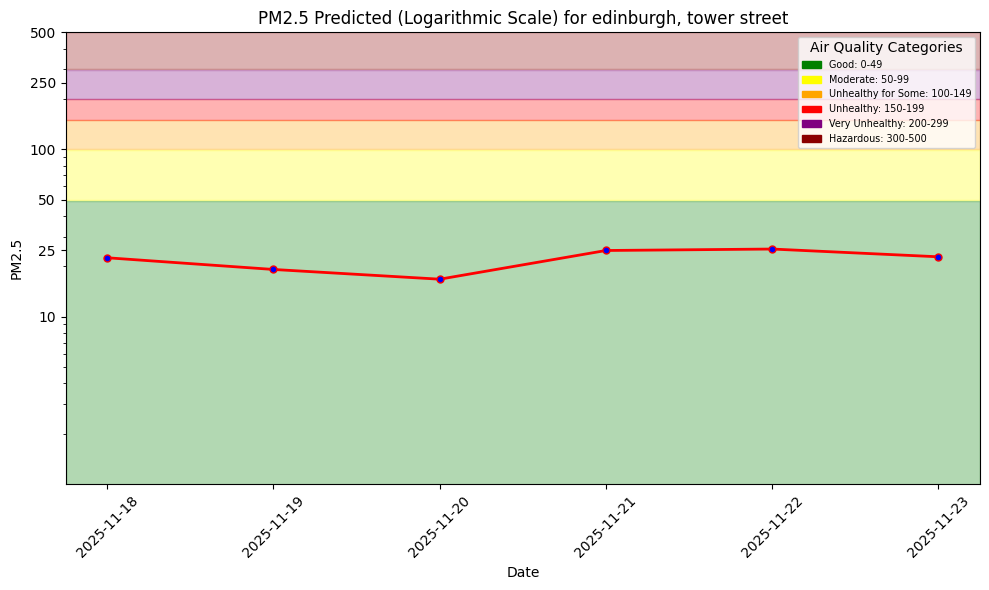

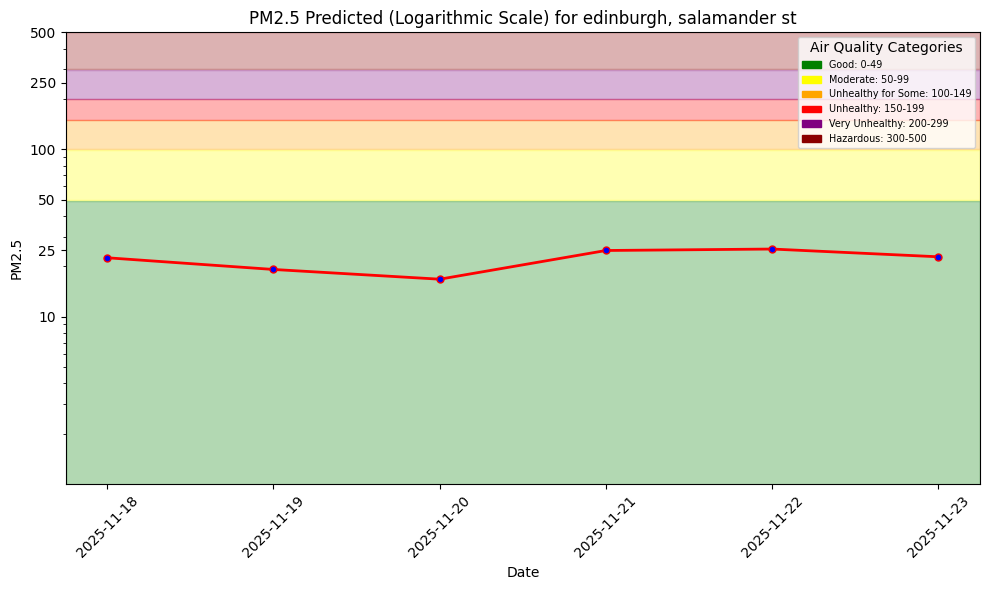

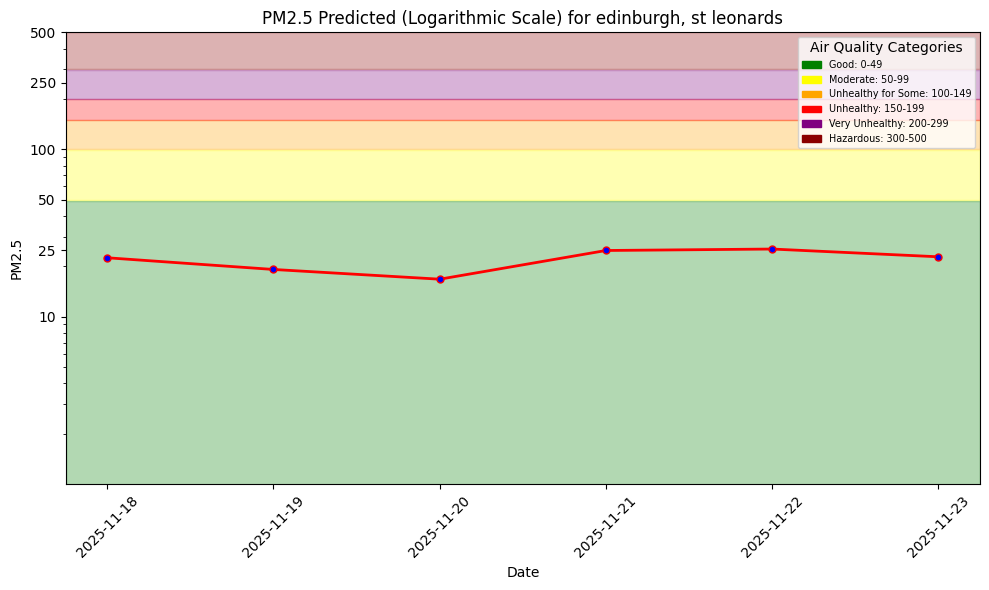

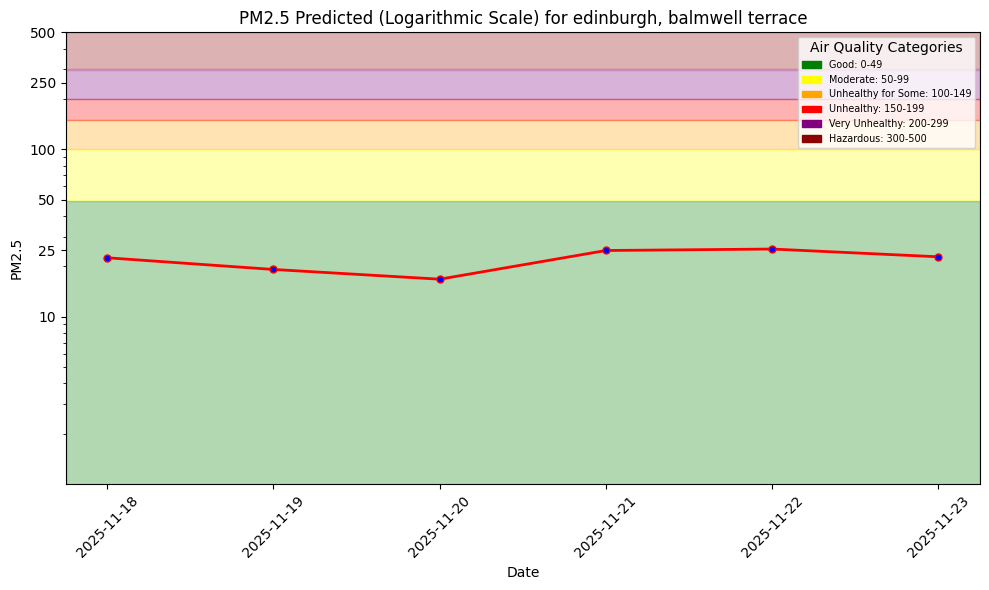

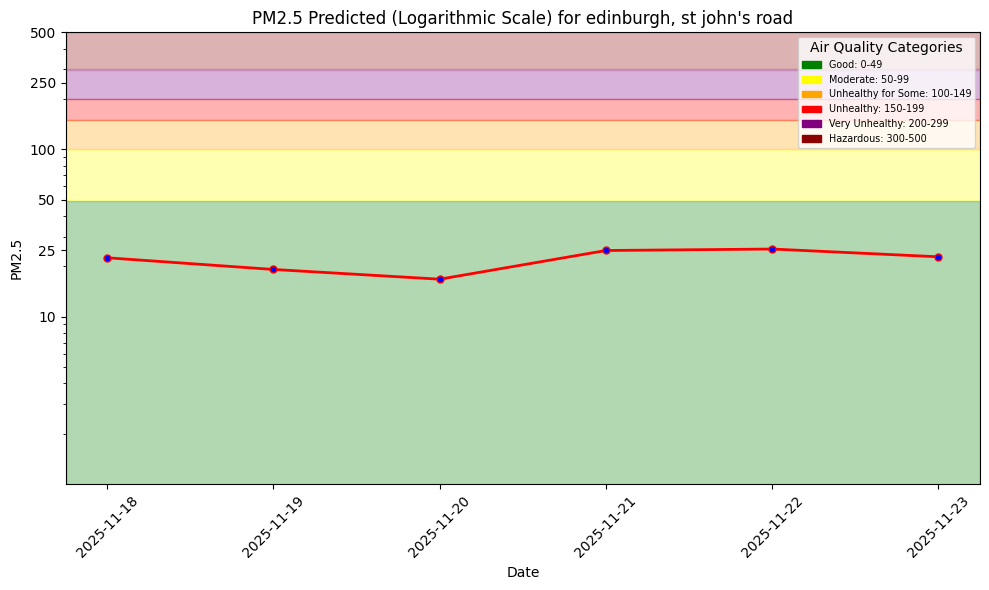

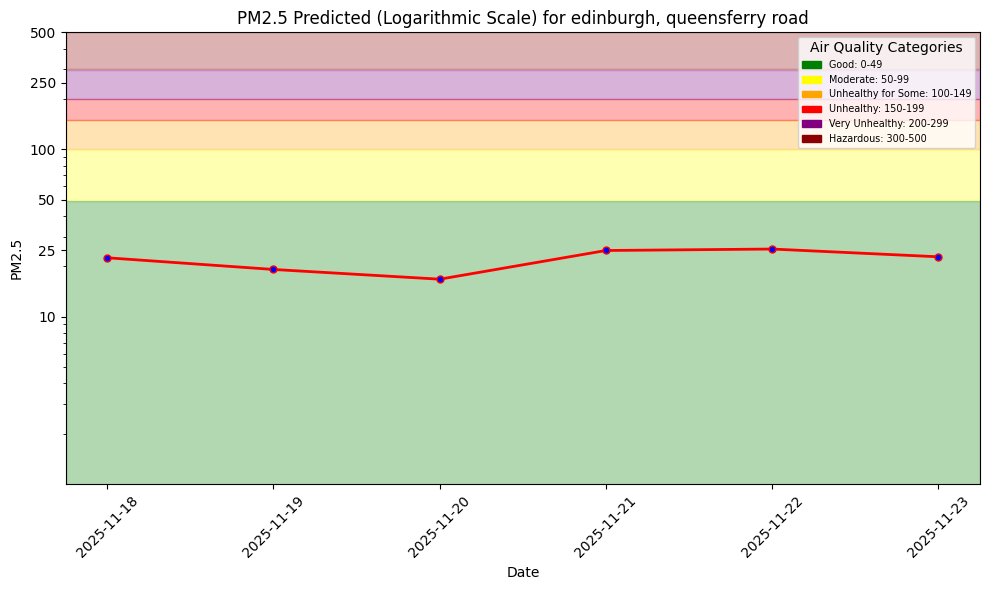

In [29]:
if running_e or running_c:
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
    plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

    plt.show()

if running_a:
    for batch_df in batch_data_frames:
        street = batch_df['street'][0]
        pred_file_path = f"{root_dir}/docs/air-quality_a/assets/img/pm25_forecast{street}.png"
        plt = util.plot_air_quality_forecast(city, street, batch_df, pred_file_path)

        plt.show()

In [ ]:
# Get or create feature group, version 2 för C
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, wait=True)

In [ ]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

In [ ]:
#Versinon 2 för del C

air_quality_fg = fs.get_feature_group(name='air_quality', version=2) #<-- byt för del C
air_quality_df = air_quality_fg.read()
air_quality_df

In [ ]:
def backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, model):
    features_df = weather_fg.read()
    all_features_df = pd.merge(air_quality_df[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days', 'date']], features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'date', 'city']])

    all_features_df = all_features_df.sort_values(by=['date'], ascending=True)
    all_features_df = all_features_df.tail(10)
   
    print(all_features_df)
    all_features_df['predicted_pm25'] = model.predict(all_features_df[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    df = pd.merge(all_features_df, air_quality_df[['date','pm25','street','country']], on="date")
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('pm25', axis=1)
    monitor_fg.insert(df, write_options={"wait_for_job": True})

    return hindcast_df
    



In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [ ]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

---